IMPORTS

In [391]:
import pandas as pd
import sklearn
import scipy
import sklearn.ensemble as forest
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import sklearn.gaussian_process as kriging
import seaborn as sns
from tensorflow import keras
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, TransformerMixin, FeatureUnion
from sklearn.preprocessing import *
from feature_engine import wrappers

# from feature_engine import
from sklearn.compose import ColumnTransformer
from sklearn import model_selection
from sklearn.gaussian_process import GaussianProcessRegressor
from feature_engine.creation import MathFeatures, RelativeFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
import optuna

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.gaussian_process.kernels import RBF
from lightgbm import LGBMRegressor

In [389]:
def rna_model(
    features_in=87,
    hidden_layer_units=32,
    optimizer=keras.optimizers.Adam,
    optimizer__learning_rate=0.001,
    dropout=0.4,
):
    rna_model = keras.models.Sequential()
    rna_model.add(keras.layers.Input(shape=(features_in,)))
    rna_model.add(keras.layers.Dense(units=(features_in + 12), activation="relu"))
    rna_model.add(keras.layers.Dense(units=hidden_layer_units))

    rna_model.add(keras.layers.Dropout(rate=dropout))

    rna_model.add(keras.layers.LeakyReLU())
    rna_model.add(keras.layers.Dense(units=hidden_layer_units))

    rna_model.add(keras.layers.LeakyReLU())

    rna_model.add(keras.layers.Dropout(rate=dropout))
    rna_model.add(keras.layers.Dense(units=1, activation="linear"))

    rna_model.compile(
        loss="mean_squared_error",
        optimizer=optimizer(learning_rate=optimizer__learning_rate),
    )

    return rna_model


class Regressor:
    def __init__(self, x: pd.DataFrame):
        # self.n_estimators=n_estimators-
        self.features_in = len(x.columns)
        self.random_state = 5
        self.models = self._define_model()
        self.models_names = list(self._define_model().keys())
        self.params_ = self._models_params()

        pass

    def search_params(self):
        search_params = {
            "RandomForestRegressor": {
                "n_estimators": 1000,
                "min_samples_split": 5,
                "min_samples_leaf": 4,
                "max_depth": None,
                "bootstrap": True,
            },
            "GradientBoostingRegressor": {
                "subsample": 1.0,
                "n_estimators": 200,
                "min_samples_split": 2,
                "min_samples_leaf": 1,
                "max_depth": 3,
                "learning_rate": 0.1,
            },
            "XGBRFRegressor": {
                "subsample": 1.0,
                "reg_lambda": 0.5,
                "reg_alpha": 0.1,
                "max_depth": 3,
                "learning_rate": 0.1,
                "gamma": 0,
                "colsample_bytree": 0.8,
            },
            "LGBMRegressor": {
                "subsample": 0.8,
                "num_leaves": 31,
                "n_estimators": 200,
                "min_child_samples": 50,
                "max_depth": 3,
                "learning_rate": 0.1,
                "colsample_bytree": 1.0,
            },
            "RNA": {
                "optimizer__learning_rate": 0.001,
                "optimizer": keras.optimizers.SGD,
                "hidden_layer_units": 64,
                "dropout": 0.4,
            },
        }
        return search_params 

    def _models_params(self):
        param_dict = {
            "RandomForestRegressor": {
                "bootstrap": [True, False],
                "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                # 'max_features': ['1.0', 'sqrt'],
                "min_samples_leaf": [1, 2, 4],
                "min_samples_split": [2, 5, 10],
                "n_estimators": [
                    200,
                    400,
                    600,
                    800,
                    1000,
                    1200,
                    1400,
                    1600,
                    1800,
                    2000,
                ],
            },
            "GradientBoostingRegressor": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.5],
                "max_depth": [3, 5, 7],
                "subsample": [0.8, 1.0],
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2],
                # 'max_features': ['sqrt', 'log2']
            },
            "XGBRFRegressor": {
                "learning_rate": [0.1, 0.01, 0.001],  # Learning rate
                "max_depth": [3, 4, 5],  # Maximum depth of each tree
                "subsample": [
                    0.8,
                    0.9,
                    1.0,
                ],  # Subsample ratio of the training instances
                "colsample_bytree": [
                    0.8,
                    0.9,
                    1.0,
                ],  # Subsample ratio of columns when constructing each tree
                "reg_alpha": [0, 0.1, 0.5],  # L1 regularization term on weights
                "reg_lambda": [0, 0.1, 0.5],  # L2 regularization term on weights
                "gamma": [
                    0,
                    0.1,
                    0.5,
                ],  # Minimum loss reduction required to make a further partition on a leaf node
            },
            "LGBMRegressor": {
                "n_estimators": [100, 200, 300],  # Number of boosting rounds
                "learning_rate": [0.01, 0.05, 0.1],  # Step size shrinkage
                "max_depth": [
                    3,
                    5,
                    7,
                    -1,
                ],  # Maximum depth of trees (-1 means no limit)
                "num_leaves": [31, 50, 100],  # Maximum number of leaves in one tree
                "min_child_samples": [
                    20,
                    50,
                    100,
                ],  # Minimum number of data points in leaves
                "subsample": [0.8, 1.0],  # Row subsampling rate
                "colsample_bytree": [0.8, 1.0],  # Feature subsampling rate
            },
            "RNA": {
                "hidden_layer_units": [32, 64, 128, 256],
                "optimizer": [
                    keras.optimizers.Adam,
                    keras.optimizers.SGD,
                    keras.optimizers.RMSprop,
                ],
                "optimizer__learning_rate": [0.1, 0.01, 0.001, 0.0001],
                "dropout": [0.1, 0.2, 0.3, 0.4, 0.5],
            },
        }

        # return [random_forest_params,gradient_boosting_regressor_params,ada_boost_regressor_params,gaussian_process_paramns,svr_params,xgb_regressor_params]
        return param_dict

    def rna_model(hidden_layer_units, optimizer):
        rna_model = keras.models.Sequential()
        rna_model.add(keras.layers.Input(shape=(28,)))
        rna_model.add(keras.layers.Dense(units=(32), activation="relu"))
        rna_model.add(keras.layers.Dense(units=hidden_layer_units))

        rna_model.add(keras.layers.LeakyReLU())
        rna_model.add(keras.layers.Dense(units=hidden_layer_units))

        rna_model.add(keras.layers.LeakyReLU())
        rna_model.add(keras.layers.Dense(units=1, activation="linear"))

        rna_model.compile(loss="mean_squared_error", optimizer=optimizer)

        return rna_model

    # def base_rna_model(self):
    #     rna_model = keras.models.Sequential()
    #     rna_model.add(keras.layers.Input(shape=(self.features_in,)))
    #     rna_model.add(keras.layers.Dense(units=(self.features_in + 5)))
    #     rna_model.add(keras.layers.Dense(units=32))
    #     rna_model.add(keras.layers.LeakyReLU())
    #     rna_model.add(keras.layers.Dense(units=32))
    #     rna_model.add(keras.layers.LeakyReLU())
    #     rna_model.add(keras.layers.Dense(units=1, activation="linear"))
    #     rna_model.compile(loss='mean_squared_error',optimizer='SGD')

    #     return rna_model

    def _define_model(self):
        models = {
            "RandomForestRegressor": RandomForestRegressor(**self.search_params()['RandomForestRegressor'],
                random_state=self.random_state
            ),
            "GradientBoostingRegressor": GradientBoostingRegressor(**self.search_params()['GradientBoostingRegressor'],
                random_state=self.random_state
            ),
            "XGBRFRegressor": XGBRegressor(**self.search_params()['XGBRFRegressor']),
            "LGBMRegressor": LGBMRegressor(**self.search_params()['LGBMRegressor']),
            # "RNA": KerasRegressor(
            #     build_fn=rna_model,
                
            #     random_state=self.random_state,
            #     batch_size=32,
            #     # hidden_layer_units=32,
            #     # optimizer="adam",
            #     epochs=250,
            #     **self.search_params()['RNA'],
            #     features_in=self.features_in,
            # ),
        }

        return models

In [388]:
Regressor(x=x_train_trans).search_param={}

Classes

In [11]:
# class ColumnTransformer(TransformerMixin):
#     def __init__(self,cols):
#         self.cols=cols

#     def transform(self,X):
#         Xcols=X[self.cols]
#         return Xcols

#     def fit(self,X,y=None):
#         return self

Tratamento Dos Dados

In [379]:
dfx = pd.DataFrame(
    pd.read_csv(
        filepath_or_buffer="DadosMetamodelagemX4.csv",
        delimiter=",",
        index_col=False,
        names=[
            "ReactionTemperature",
            "H2FlowRate",
            "SplitsValues",
            "RefluxRatio",
            "ReactorVolume",
            "FeedPressure",
            "NANx",
        ],
    )
)
dfy = pd.DataFrame(
    pd.read_csv(
        "DadosMetamodelagemY4.csv",
        delimiter=",",
        names=[
            "ISBL",
            "CustoMateriaPrima",
            "CustoUtilidades",
            "Methanol",
            "IsValid",
            "IsConverged",
            "StreamConvergeance",
            "NANy",
        ],
    )
)
dfy["Methanol"] = dfy["Methanol"] * 46.031 * 575 / 1000


dft = pd.DataFrame.join(dfx, dfy)
dft.drop(dft.loc[dft["StreamConvergeance"] == False].index, inplace=True)
dft.drop(
    columns=["NANx", "NANy", "IsValid", "StreamConvergeance", "IsConverged"],
    inplace=True,
)
dft.reset_index(inplace=True, drop=True)
dft.astype(dtype=float, copy=True)
dft["ISBL"] = dft["ISBL"].astype(float)

df_isbl = dft["ISBL"]
df_osbl = df_isbl * 0.35
df_opex = dft["CustoMateriaPrima"] + dft["CustoUtilidades"]
df_capex = (
    (
        df_isbl
        + df_osbl
        + 0.20 * (df_osbl + df_isbl)
        + 0.30 * (df_osbl + df_isbl)
        + 0.15 * (df_osbl + df_isbl)
    )
    / 12
    / 30
    / 24
)
df_profit = pd.DataFrame(dft["Methanol"] - df_capex - df_opex, columns=["Profit"])

to_drop = ["ISBL", "CustoMateriaPrima", "CustoUtilidades", "Methanol"]
dft.drop(labels=to_drop, inplace=True, axis=1)
dft = dft.join(df_profit)

target = ["Profit"]
features = [
    "ReactionTemperature",
    "H2FlowRate",
    "SplitsValues",
    "RefluxRatio",
    "ReactorVolume",
    "FeedPressure",
]

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    dft[features], dft[target], test_size=0.33
)
train_test_data_list = [x_train, x_test, y_train, y_test]
for i in train_test_data_list:
    i.reset_index(inplace=True, drop=True)
df_train = x_train.join(y_train)
df_test = x_test.join(y_test)

HeatMap Das Correlações

<Axes: >

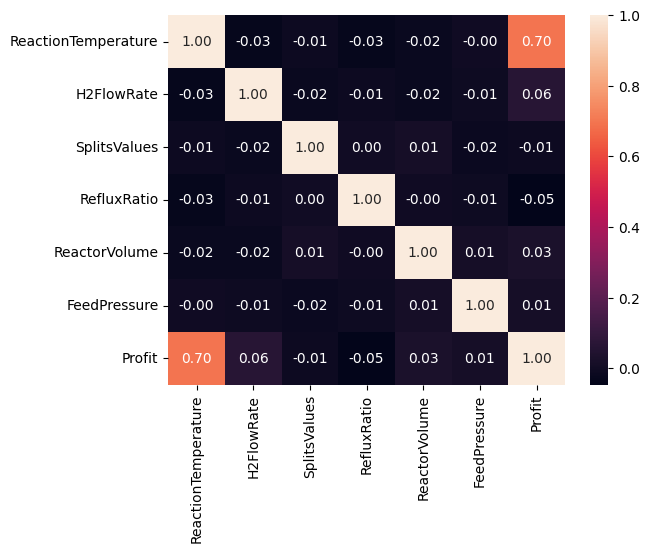

In [13]:
sns.heatmap(dft.corr(), annot=True, annot_kws={"size": "10"}, fmt=".2f")

ISBL , CustoUtilidades e CustoMateriaPrima são Targets redundantes, portanto TAC, Methanol e serão trabalhados

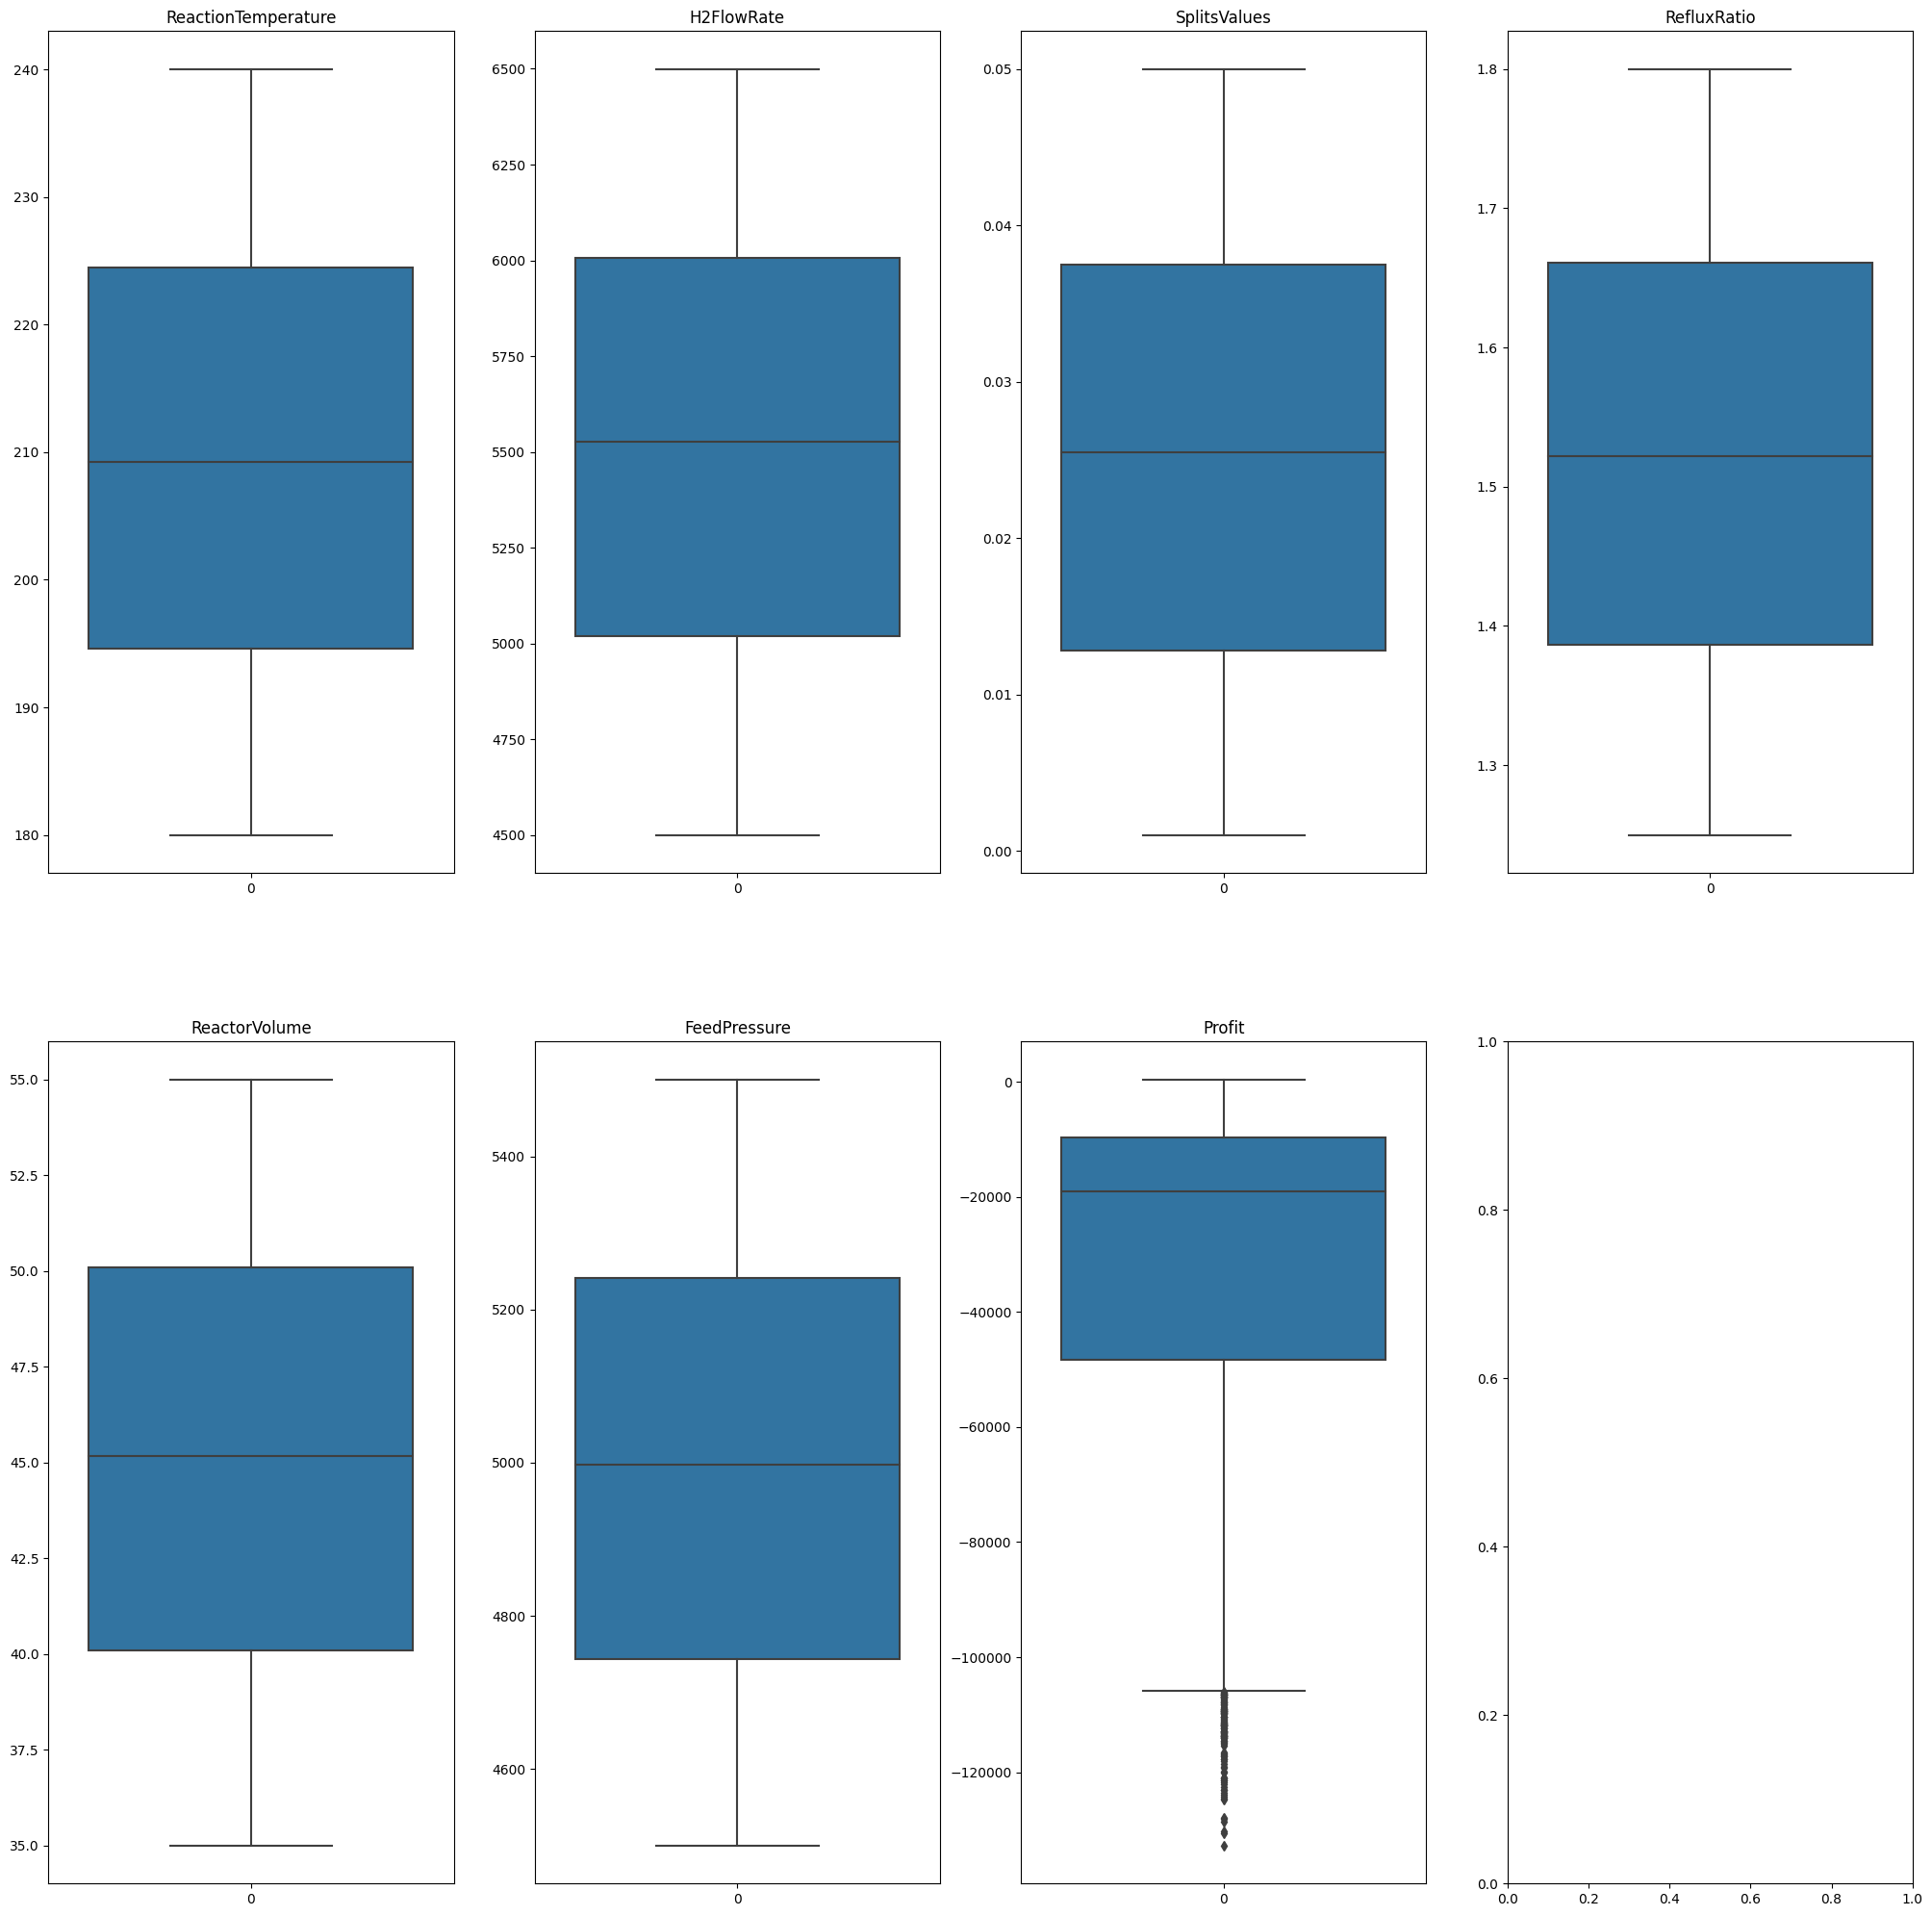

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(25, 25))
axesf = axes.flatten()
for i, columns in enumerate(dft.columns.to_list()):
    ax = axesf[i]
    ax.set_title(columns)
    sns.boxplot(df_train[columns], ax=ax)

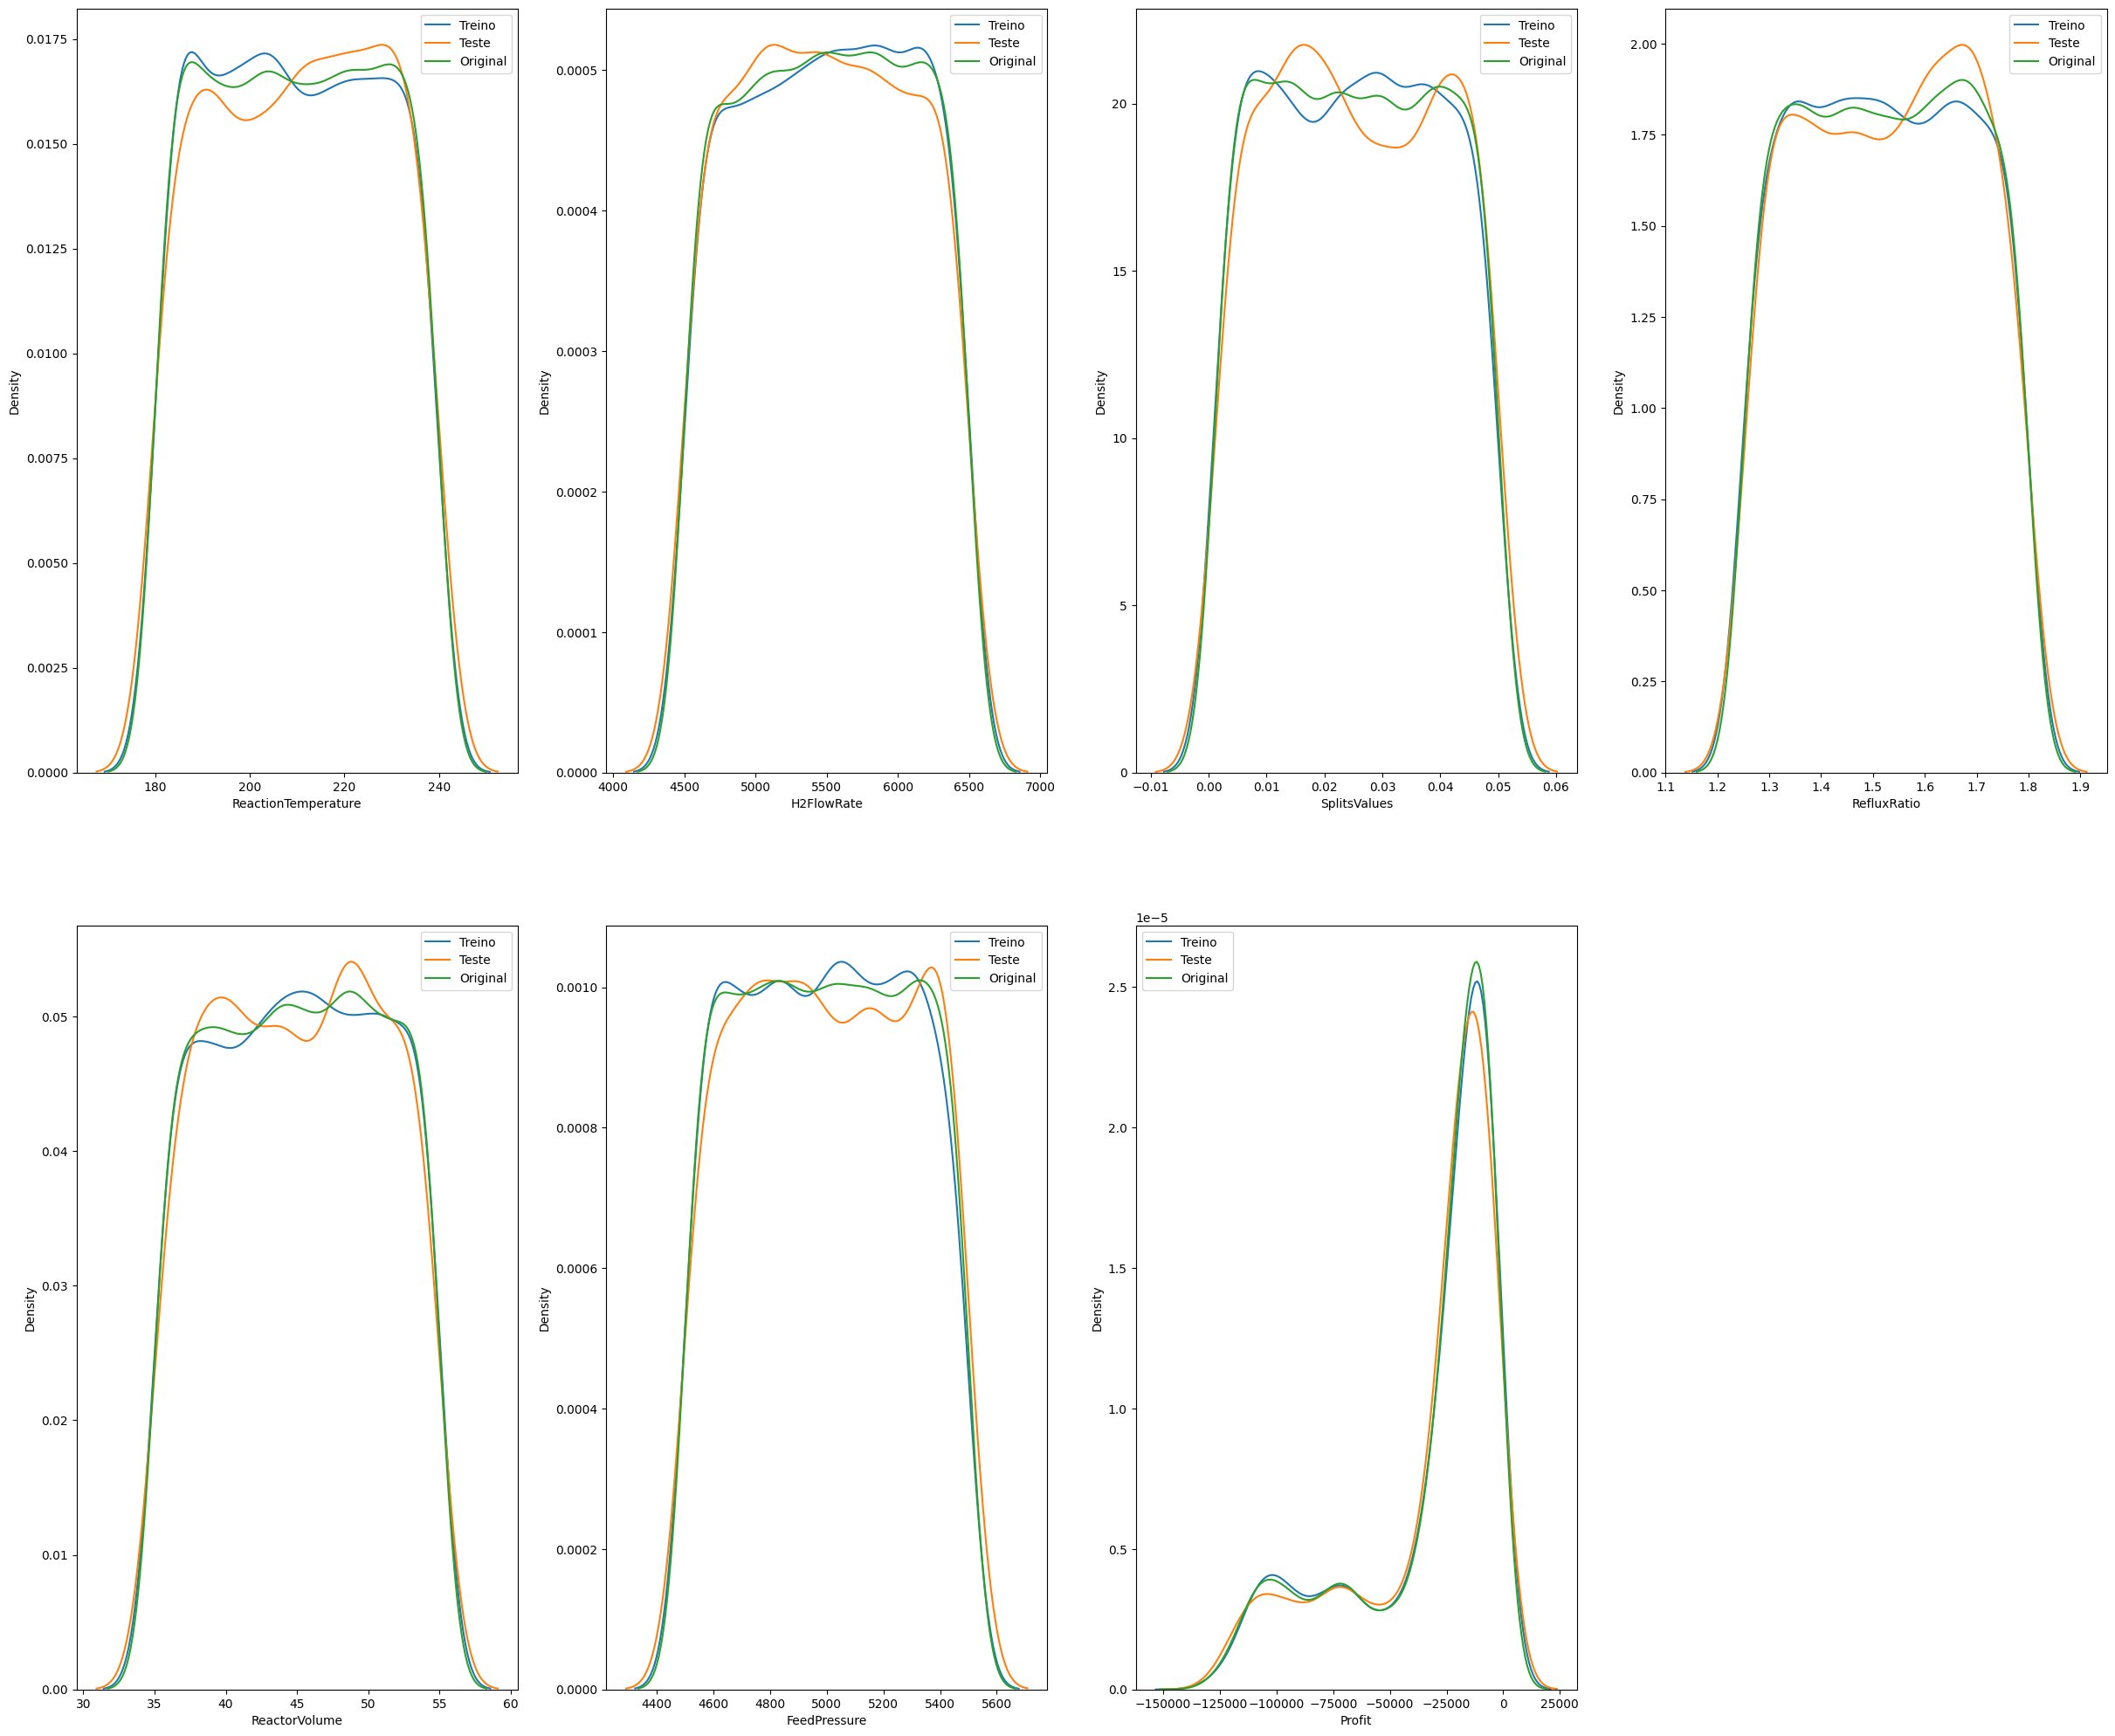

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(30, 25))
fig.delaxes(axes[1, 3])
axesf = axes.flatten()
for i, columns in enumerate(dft.columns.to_list()):
    ax = axesf[i]
    sns.kdeplot(df_train[columns], ax=ax)
    sns.kdeplot(df_test[columns], ax=ax)
    sns.kdeplot(dft[columns], ax=ax)
    ax.legend(["Treino", "Teste", "Original"])

Data engineering e análise dos modelos

In [380]:
x_train_trans = x_train
x_test_trans = x_test
y_train_trans = y_train
y_test_trans = y_test


target_transformer = Pipeline([("target_transformer", RobustScaler())])
# ("BoxCox", preprocessing.PowerTransformer(method="box-cox", copy=False)),

y_train_trans = target_transformer.fit_transform(y_train_trans)
y_test_trans = target_transformer.transform(y_test_trans)

feature_trans = Pipeline(
    [
        # ("PolynomialFeatures", PolynomialFeatures(4, interaction_only=False)),
        ("LOG", FunctionTransformer(func=np.log)),
        ("StandardScaler", StandardScaler()),
    ]
)
feature_trans.set_output(transform="pandas")
x_train_trans = feature_trans.fit_transform(x_train_trans)
x_test_trans = feature_trans.transform(x_test_trans)

regressor = Regressor(x=x_train_trans)
models = regressor.models
parameters = regressor._models_params()
best_params = {}
scores = {}
models_list = {}
# scoring={'r2':metrics.make_scorer(metrics.r2_score),'neg_mean_squared_error':metrics.make_scorer(metrics.mean_squared_error)}

for name, model in models.items():
    gs = model_selection.cross_validate(
        estimator=model,
        X=x_train_trans,
        y=np.ravel(y_train_trans),
        cv=3,
        scoring="r2",
        verbose=0,
    )
    scores.update({name: gs["test_score"]})
    models_list.update({name: gs})
    print("Modelo:{}\n score: {}".format(*[name, scores[name]]))

print(scores)

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Modelo:RandomForestRegressor
 score: [0.93974779 0.94741488 0.94541426]
Modelo:GradientBoostingRegressor
 score: [0.93643446 0.94366685 0.94101072]
Modelo:XGBRFRegressor
 score: [0.93852204 0.94532228 0.94379556]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1794, number of used features: 6
[LightGBM] [Info] Start training from score -0.367162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 1ms/step


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 1ms/step


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 1ms/step
Modelo:RNA
 score: [0.36806386 0.39375186 0.3827297 ]
{'RandomForestRegressor': array([0.93974779, 0.94741488, 0.94541426]), 'GradientBoostingRegressor': array([0.93643446, 0.94366685, 0.94101072]), 'XGBRFRegressor': array([0.93852204, 0.94532228, 0.94379556]), 'LGBMRegressor': array([0.93971238, 0.94675109, 0.94508488]), 'RNA': array([0.36806386, 0.39375186, 0.3827297 ])}


In [341]:
x_train_trans = x_train
x_test_trans = x_test
y_train_trans = y_train
y_test_trans = y_test


target_transformer = Pipeline(
    [
        ("target_transformer", RobustScaler()),
        # ("BoxCox", preprocessing.PowerTransformer(method="box-cox", copy=False)),
    ]
)
target_transformer.set_output(transform="pandas")
y_train_trans = target_transformer.fit_transform(y_train_trans)
y_test_trans = target_transformer.transform(y_test_trans)

feature_trans = Pipeline(
    [
        ("PolynomialFeatures", PolynomialFeatures(3, interaction_only=False)),
        
        # ("LOG", FunctionTransformer(func=np.log)),
        ("StandardScaler", StandardScaler()),
    ]
)
feature_trans.set_output(transform="pandas")
x_train_trans = feature_trans.fit_transform(x_train_trans)
x_test_trans = feature_trans.transform(x_test_trans)

regressor = Regressor(x=x_train_trans)
models = regressor.models
parameters = regressor._models_params()
best_params = {}
scores = {}
models_list = {}
# scoring={'r2':metrics.make_scorer(metrics.r2_score),'neg_mean_squared_error':metrics.make_scorer(metrics.mean_squared_error)}

for name, model in models.items():

    gs = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameters[name],
        cv=3,
        scoring='r2',
        verbose=2
        )
    gs.fit(x_train_trans,np.ravel(y_train_trans))
    scores.update({name:gs.best_score_})
    models_list.update({name:gs})
    best_params.update({name:gs.best_params_})
    print("Modelo:{}\n score: {}".format(*[name, scores[name]]))

print(parameters)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 2.9min
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 2.9min
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 2.9min
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 1.2min
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 1.3min
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time= 1.3min
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total time= 2.3min
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=2, n_estimators=1400; total tim

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/250
57/57 [==============================] - 1s 6ms/step - loss: 0.3120
Epoch 2/250
57/57 [==============================] - 0s 4ms/step - loss: 0.1254
Epoch 3/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0783
Epoch 4/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0718
Epoch 5/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0614
Epoch 6/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0640
Epoch 7/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0681
Epoch 8/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0558
Epoch 9/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0504
Epoch 10/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0552
Epoch 11/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0507
Epoch 12/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0575
Epoch 13/250
57/57 [=================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 4ms/step - loss: 0.3048
Epoch 2/250
57/57 [==============================] - 0s 4ms/step - loss: 0.1112
Epoch 3/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0943
Epoch 4/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0776
Epoch 5/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0766
Epoch 6/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0634
Epoch 7/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0635
Epoch 8/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0569
Epoch 9/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0531
Epoch 10/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0599
Epoch 11/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0541
Epoch 12/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0532
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 3ms/step - loss: 0.2865
Epoch 2/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1005
Epoch 3/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0882
Epoch 4/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0743
Epoch 5/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 6/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 7/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0630
Epoch 8/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 9/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0514
Epoch 10/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0563
Epoch 11/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0508
Epoch 12/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0501
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/250
57/57 [==============================] - 1s 2ms/step - loss: 0.4506
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1999
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1456
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1291
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1128
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1123
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1015
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1054
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0904
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0855
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0858
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0931
Epoch 13/250
57/57 [=================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5034
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2126
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1756
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1398
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1227
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1171
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1090
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1044
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0993
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0871
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0979
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0863
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.4816
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2117
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1647
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1362
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1151
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1239
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1004
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0960
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0972
Epoch 10/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0931
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0896
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0825
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.9285
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.4099
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.3138
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2631
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2241
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2326
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2440
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1987
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1866
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1869
Epoch 11/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1749
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1817
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.9487
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.3992
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.3282
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2729
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2601
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2335
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2168
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2168
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1987
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1963
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1772
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1775
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.8622
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.3861
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.3183
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2645
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2474
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2349
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1910
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1951
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1675
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1823
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1643
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1718
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5588
Epoch 2/250
57/57 [==============================] - 0s 4ms/step - loss: 0.2598
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1778
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1479
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1364
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1341
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1193
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1199
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1075
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1054
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1049
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0985
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 3ms/step - loss: 0.5952
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2718
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1707
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1321
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1238
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1328
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1148
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1115
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1138
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0964
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5676
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2712
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2085
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1617
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1359
Epoch 6/250
57/57 [==============================] - 0s 4ms/step - loss: 0.1310
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1227
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1298
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1084
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1096
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1044
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5588
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2598
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1778
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1479
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1364
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1341
Epoch 7/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1193
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1199
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1075
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1054
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1049
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0985
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5952
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2718
Epoch 3/250
57/57 [==============================] - 0s 3ms/step - loss: 0.2152
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1707
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1321
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1238
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1328
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1148
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1115
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1138
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0964
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5676
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2712
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2085
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1617
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1359
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1310
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1227
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1298
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1084
Epoch 10/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1096
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1044
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 3ms/step - loss: 0.5446
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2065
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1494
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1300
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1093
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1102
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0981
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0912
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0931
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0787
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0788
Epoch 12/250
57/57 [==============================] - 0s 4ms/step - loss: 0.0813
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5583
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2127
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1606
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1377
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1255
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1143
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1142
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1000
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0974
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0856
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5332
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2062
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1644
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1291
Epoch 5/250
57/57 [==============================] - 0s 4ms/step - loss: 0.1212
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1045
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1016
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0911
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0891
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0901
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0931
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0882
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.3350
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1324
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1004
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0880
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0784
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0787
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0709
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0681
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0613
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0566
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0653
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0661
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.3561
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1348
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1149
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0950
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0820
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0751
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0722
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0733
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0663
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0642
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0679
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0607
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.3583
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1398
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1086
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0833
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0788
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0787
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0701
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0688
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0657
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0575
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.3143
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1240
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0905
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0795
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0683
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0706
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0614
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0557
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0555
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.3226
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1264
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1119
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0839
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0772
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0695
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0713
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0666
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0650
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0589
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0598
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0621
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.3143
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1190
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1037
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0827
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0736
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0680
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0653
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0604
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0623
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0607
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0576
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 3ms/step - loss: 0.3353
Epoch 2/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1379
Epoch 3/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0957
Epoch 4/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0879
Epoch 5/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0690
Epoch 6/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 7/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 8/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 9/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0560
Epoch 10/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 11/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0623
Epoch 12/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0779
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 3ms/step - loss: 0.3348
Epoch 2/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1271
Epoch 3/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1017
Epoch 4/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0926
Epoch 5/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0837
Epoch 6/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0741
Epoch 7/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 8/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 9/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0634
Epoch 10/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 11/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 12/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 4ms/step - loss: 0.3166
Epoch 2/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1240
Epoch 3/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1043
Epoch 4/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0864
Epoch 5/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 6/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 7/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0701
Epoch 8/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0633
Epoch 9/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 10/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0594
Epoch 11/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 12/250
57/57 [==============================] - 0s 3ms/step - loss: 0.0546
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5588
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2598
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1778
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1479
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1364
Epoch 6/250
57/57 [==============================] - 0s 3ms/step - loss: 0.1341
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1193
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1199
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1075
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1054
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1049
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0985
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5952
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2718
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2152
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1707
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1444
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1321
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1238
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1328
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1148
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1115
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1138
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0964
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 2ms/step - loss: 0.5676
Epoch 2/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2712
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 0.2085
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1617
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1359
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1310
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1227
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1298
Epoch 9/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1084
Epoch 10/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1096
Epoch 11/250
57/57 [==============================] - 0s 2ms/step - loss: 0.1044
Epoch 12/250
57/57 [==============================] - 0s 2ms/step - loss: 0.0937
Epoch 13/250
57/57 [=============================

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


85/85 [==============================] - 1s 3ms/step - loss: 0.4573
Epoch 2/250
85/85 [==============================] - 0s 2ms/step - loss: 0.2032
Epoch 3/250
85/85 [==============================] - 0s 2ms/step - loss: 0.1557
Epoch 4/250
85/85 [==============================] - 0s 2ms/step - loss: 0.1298
Epoch 5/250
85/85 [==============================] - 0s 2ms/step - loss: 0.1209
Epoch 6/250
85/85 [==============================] - 0s 2ms/step - loss: 0.1237
Epoch 7/250
85/85 [==============================] - 0s 2ms/step - loss: 0.1065
Epoch 8/250
85/85 [==============================] - 0s 2ms/step - loss: 0.1034
Epoch 9/250
85/85 [==============================] - 0s 2ms/step - loss: 0.0959
Epoch 10/250
85/85 [==============================] - 0s 2ms/step - loss: 0.0974
Epoch 11/250
85/85 [==============================] - 0s 2ms/step - loss: 0.0968
Epoch 12/250
85/85 [==============================] - 0s 2ms/step - loss: 0.0930
Epoch 13/250
85/85 [=============================

In [392]:
features_to_drop={}
for name, model in Regressor(x_train_trans).models.items():
    gs=RFECV(model,cv=3, scoring='r2',)
    gs.fit(x_train_trans,np.ravel(y_train_trans))
    features_to_drop.update({name:gs.support_})

AttributeError: 'KerasRegressor' object has no attribute 'items'